# Dictionary Analysis

As second method the dictionary analysis is used to identify and count comments from lateral thinkers. The dictionary analysis is a very simple method and is derived from sentiment analysis. Due to the simplicity of the model, the results must be critically examined and questioned at the end. For example, due to the bag-of-words representation in the model, we cannot take negations into account, which can lead to misleading results {cite:p}`atteveldt_computational_2022`.

The dictionary used is the RPX-Lex dictionary, which was developed to measure German right-wing populist conspiracy discourse {cite:p}`rpc_lex_dictionary`. The dictionary contains 14,105 terms which are divided into 13 categories, such as Suspicion, Antisemitism or Esotericism {cite:p}`rpc_lex_dictionary`. It should be noted, that some terms appear in more than one category, as they are assigned to several categories. This circumstance will be taken into account later in the analysis so that hits are not counted twice.

First, we load the dictionary and as we can see, it contains 14,105 terms as stated in the paper.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from cleantext import clean
from tqdm import tqdm

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [3]:
rpx_dict = pd.read_csv("dictionary_analysis/rpc_lex.csv", delimiter=";")
display(rpx_dict[["term", 'category_en']])

,term,category_en
0,-etage,Scandalization
1,#abgase,Scandalization
2,#kreuzfahrtschiffe,Scandalization
3,#schwerölverbrennung,Scandalization
4,#umweltskandal,Scandalization
...,...,...
14100,wurzelrassenlehre,Esotericism
14101,z-plan,Esotericism
14102,zahlenmystik,Esotericism
14103,zeitenwende,Esotericism


Then we define the method for the dictionary analysis. The comment is passed to the method and first it is split into a list of words. After that it iterates over each term in the dictionary. First it checks if the term already occurs in the identified terms and if so the iteration is skipped. This check is necessary to skip terms that are part of several categories and therefore already identified. Since the dictionary contains not only single words, but also phrases with several words, we need to take these into account. If the dictionary term is a phrase, it is checked whether the phrase occurs in the text or not, and if the dictionary term is a single word, it is checked whether the word occurs in the list of words created at the beginning.

In [4]:
def get_dictionary_analysis_term_occurrence(text: str):
    term_occurrence = 0
    identified_terms = []
    text_tokens = set(text.split(" "))
    for term in rpx_dict.term.to_list():
        if term in identified_terms:
            continue # Skip terms that have already been identified but occur in multiple categories

        if " " in term:
            if term in text: # Dictionary term consists of several words
                term_occurrence+=1
                identified_terms.append(term)
        else:
            if term in text_tokens: # Dictionary term is a single word
                term_occurrence+=1
                identified_terms.append(term)
    return term_occurrence, identified_terms

Before the dictionary analysis can be performed, a bit of preprocessing is required. As before, we load the comments and make sure they are all in string format. Then a function is defined which removes emojis, links and mentions. This method is then applied to all comments. In the end all empty comments are removed, which are basically all comments that only contain emojis.

In [5]:
comments_df = pd.read_csv("data/youtube_comments_500.csv")
comments_df["Comments"] = comments_df["Comments"].astype(str)

def clean_text(text:str):
    text = clean(text, no_emoji=True, lang="de")
    new_text = []
    for token in text.split(" "):
        if not token.startswith('@') and not token.startswith('http'):
            new_text.append(token)
    return " ".join(new_text)

comments_df["Comments"] = comments_df["Comments"].apply(lambda text: clean_text(text))
comments_df = comments_df[comments_df.Comments != ""]

Iterating over all comments to apply the dictionary analysis takes several minutes. In the end, two columns are added to the dataframe. One contains the number of dictionary terms found and the other a list of the terms found. We can see that 345,620 comments contain at least one term from the dictionary, which corresponds to 85% of all comments.

In [6]:
dict_term_occurrence_list = []
dict_identified_terms_list = []

for text in tqdm(comments_df.Comments.to_list()):
    occurrence_counter, identified_terms_list = get_dictionary_analysis_term_occurrence(text)
    dict_term_occurrence_list.append(occurrence_counter)
    dict_identified_terms_list.append(identified_terms_list)

comments_df["dict_term_occurrence"] = dict_term_occurrence_list
comments_df["dict_identified_terms_list"] = dict_identified_terms_list
comments_df.to_csv("data/dictionary_analysis.csv", index=False)

100%|██████████| 401282/401282 [07:10<00:00, 932.33it/s] 


In [9]:
display(comments_df.loc[comments_df['dict_term_occurrence'] > 0])

,Unnamed: 0,Comments,dict_term_occurrence,dict_identified_terms_list
0,0,wollt ihr jetzt jeden tag einen großen bericht...,7,"[ganz, großen, bericht, schön, panzer, sinnlos..."
1,1,"wenn scholz alles besser weiss, wieso braucht ...",3,"[braucht, wieso, besser]"
2,2,die grünen hatten früher das peace zeichen als...,9,"[grünen, heute, militär, panzer, wächst, frühe..."
3,3,der westen ist ein kriegstreiber bis es zu ein...,6,"[kommt, lange, idioten, kriegstreiber, westen,..."
4,4,frieden schaffen ohne waffen.,2,"[schaffen, frieden]"
...,...,...,...,...
406236,406236,"was die union wieder will, die leute sind doch...",10,"[land, leute, sollen, sowieso, wäre, brauchen,..."
406237,406237,"kann jeder deutscher werden ,kein problem sola...",9,"[gehen, deutsche, überwacht, irgendwelche, arb..."
406238,406238,dann nimm die leute bei dir auf und verpflege ...,1,[leute]
406239,406239,als staatenloser hatt mans aber auch nicht lei...,1,[stimmt]


If we look at a histogram of the distribution of the number of hits, we can see that many comments contain only a few words from the dictionary.

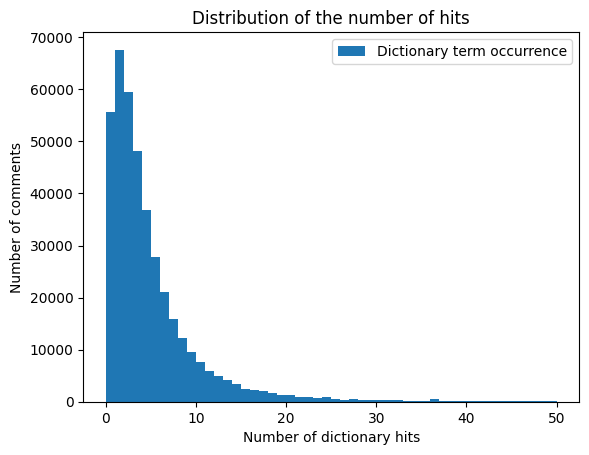

In [37]:
hist = comments_df.plot.hist(column="dict_term_occurrence", legend=False, bins=50, range=[0,50])
hist.set_xlabel("Number of dictionary hits")
hist.set_ylabel("Number of comments")
hist.set_title("Distribution of the number of hits")
hist.legend(["Dictionary term occurrence"])

Since many comments contain only a few terms from the dictionary, it might be interesting to see how the comment style changes if one only select comments that contain several terms from the dictionary. The number of comments containing more than four terms from the dictionary is already much smaller. Four or more terms contain only 133,700 comments, which corresponds to 33% of all comments.

In [38]:
display(comments_df.loc[comments_df['dict_term_occurrence'] > 4])

,Unnamed: 0,Comments,dict_term_occurrence,dict_identified_terms_list
0,0,wollt ihr jetzt jeden tag einen großen bericht...,7,"[ganz, großen, bericht, schön, panzer, sinnlos..."
2,2,die grünen hatten früher das peace zeichen als...,9,"[grünen, heute, militär, panzer, wächst, frühe..."
3,3,der westen ist ein kriegstreiber bis es zu ein...,6,"[kommt, lange, idioten, kriegstreiber, westen,..."
7,7,"donnor, beweis deine behauptung, die ukraine w...",5,"[deutschland, beweis, ukraine, wagenknecht, so..."
10,10,der fraktionslose bundestagsabgeordnete robert...,12,"[eigenen, geht, politische, traut, dabei, klar..."
...,...,...,...,...
406222,406222,und außerdem kann sich jeder im krankenhaus be...,5,"[kohle, lassen, völlig, sachen, außer]"
406223,406223,du hast es nicht verstanden junge ..\ndie ampe...,7,"[deutschland, junge, hast, leben, arbeiten, eu..."
406233,406233,deutschland hat fertig!\nausbildung fehlanzeig...,5,"[deutschland, gerne, unsere, bestimmt, rentner]"
406236,406236,"was die union wieder will, die leute sind doch...",10,"[land, leute, sollen, sowieso, wäre, brauchen,..."


In order to check the analysis, random examples from the comments are selected and classified below. If a sample is taken from all comments that contain at least one term from the dictionary, the following comments can be assigned to the lateral thinking movement:

- Sample 392575
- Sample 99556
- Sample 128489
- (Sample 318015)
- Smaple 64994
- (Sample 4130)

In [40]:
for index, values in comments_df.loc[comments_df['dict_term_occurrence'] > 0].sample(10)[
    ["Comments", "dict_identified_terms_list"]].iterrows():
    print(f"Sample {index + 1}: {values['dict_identified_terms_list']}\n")
    print(values["Comments"])
    print("-" * 150)

Sample 392575: ['deutschland', 'frauen', 'zieht', 'geburtenrate']

"taliban verbannen frauen von universitäten" - deutschland 2050 dank invasion, geburtenrate und des vernichtungshasses der ökobolschewisten. zieht euch warm an, mädels.
------------------------------------------------------------------------------------------------------------------------------------------------------
Sample 99556: ['bereicherern', 'bilder', 'zeigt', 'lieber', 'staatsfunk', 'zeigen', 'ausländischen']

hat der staatsfunk keine bilder von den bereicherern zeigen wollen? ihr zeigt lieber bilder von ausländischen faschisten.
------------------------------------------------------------------------------------------------------------------------------------------------------
Sample 128489: ['blödsinn', 'einfach', 'mitbekommen', 'rest', 'warum', 'arzt', 'politiker']

ich habe auch schon während der "maskenpflicht" keine maske getragen. ich habe mir einfach ein attest vom arzt geholt und fertig. ich habe mich n

To check the quality of the dictionary analysis, we also look at how many hits can be confirmed if at least 4 or 10 words from the dictionary appear in the comment. With at least 4 comments, the following samples can be assigned to the lateral thinking movement:

- Sample 320027
- Sample 380858
- Sample 289717
- Sample 363650

In [45]:
for index, values in comments_df.loc[comments_df['dict_term_occurrence'] > 4].sample(10)[["Comments", "dict_identified_terms_list"]].iterrows():
    print(f"Sample {index+1}: {values['dict_identified_terms_list']}\n")
    print(values["Comments"])
    print("-"*150)

Sample 320027: ['arbeit', 'dafür', 'artikel', 'merkt', 'sklaven', 'sklaverei', 'spielen', 'niemals', 'reichen', 'gesellschaft', 'solange', 'naja', 'normaler']

chancengleichheit sind leere versprechen. mit normaler arbeit wird man niemals reich. ihr sklaven dürft die supersportwagen jachten luxus artikel und villas für die reichen bauen. und kriegt dafür hungerlohn. ist das gerechtigkeit?
oder moderne sklaverei mit vorzügen. naja wenn kümmert es, spielen ja alle brav mit. solange es klassen gesellschaft gibt. aber nichts ist für ewig. merkt euch meine wörter.
------------------------------------------------------------------------------------------------------------------------------------------------------
Sample 380858: ['seit', 'sollen', 'wegen', 'irgendeine', 'teppich', 'themen', 'kurze', 'chinesen', 'gestern']

themen der sendung:
00:00 - hi ihr ottos
00:21 - mccarthy seit gestern nicht beliebter geworden
03:33 - chinesen sollen bei einreise auf vertrauenswürdigkeit getestet werde

With at least 4 comments, the following samples can be assigned to the lateral thinking movement:

- Smaple 88531
- Sample 158036
- Sample 308754
- Sample 124415
- Sample 341145
- Sample 205747

In [48]:
for index, values in comments_df.loc[comments_df['dict_term_occurrence'] > 10].sample(10)[["Comments", "dict_identified_terms_list"]].iterrows():
    print(f"Sample {index+1}: {values['dict_identified_terms_list']}\n")
    print(values["Comments"])
    print("-"*150)

Sample 88531: ['deutschland', 'eigenen', 'falsche', 'geht', 'sowas', 'brauchen', 'wie', 'welt', 'gelöst', 'genug', 'probleme', 'verdienst', 'china']

cruhser
oh, falsche antwort, 1. mein verdienst ist überdurchschnittlich und geht dich ein scheißdreck an. und 2. ist mir die baerbock sowas von scheißegal, die fährt durch die welt und verhält sich wie ein holzklotz und will auch noch china ans bein pischern. die ist behindert man. und es geht darum das wir im eigenen land, in deutschland genug probleme haben, die erstmal gelöst werden müssen. und sollche steuergeldverteilerrin brauchen wir schon mal garnicht.
du intelligenzbestie.
------------------------------------------------------------------------------------------------------------------------------------------------------
Sample 158036: ['deutschland', 'eins', 'kommen', 'kotzt', 'zwei', 'beitrag', 'schwer', 'tage', 'tote', 'reichsbürger', 'messer', 'asylbewerber', 'mädchen']

es war wieder klar, dass zwei tage nachdem ein asylbewe